In [3]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer,f1_score,precision_score,recall_score,classification_report,confusion_matrix
import joblib
import warnings
import os

In [4]:
#Importing the full dataset to see the columns

# Load only first 10 rows for memory efficiency
df_sample = pd.read_csv('../data/datasets/2019-Oct.csv', nrows=10)

df_sample.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [5]:
# Load only necessary columns for memory efficiency
columns_to_use = ['event_time', 'event_type', 'category_code', 'user_id', 'price', 'brand']
oct_df = pd.read_csv('../data/datasets/2019-Oct.csv', usecols=columns_to_use)
oct_df = oct_df[oct_df['category_code'].notna() & 
                oct_df['category_code'].str.startswith('apparel', na=False)]
oct_df['subcategory'] = oct_df['category_code'].str.split('.').str[1]
print(f"October apparel events: {len(oct_df):,}")

# Process November data
print("Processing November data...")
nov_df = pd.read_csv('../data/datasets/2019-Nov.csv', usecols=columns_to_use)
nov_df = nov_df[nov_df['category_code'].notna() & 
                nov_df['category_code'].str.startswith('apparel', na=False)]
nov_df['subcategory'] = nov_df['category_code'].str.split('.').str[1]
print(f"November apparel events: {len(nov_df):,}")

October apparel events: 1,542,924
Processing November data...
November apparel events: 3,011,101


In [6]:
oct_df.describe()

,price,user_id
count,1.542924e+06,1.542924e+06
mean,8.159051e+01,5.330701e+08
std,4.646468e+01,1.801878e+07
min,0.000000e+00,2.646498e+08
25%,5.122000e+01,5.158685e+08
50%,7.336000e+01,5.283508e+08
75%,1.047600e+02,5.501026e+08
max,9.137900e+02,5.662796e+08


In [7]:
oct_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1542924 entries, 8 to 42448754
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   event_time     1542924 non-null  object 
 1   event_type     1542924 non-null  object 
 2   category_code  1542924 non-null  object 
 3   brand          1130998 non-null  object 
 4   price          1542924 non-null  float64
 5   user_id        1542924 non-null  int64  
 6   subcategory    1542924 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 94.2+ MB


In [8]:
# Combine filtered datasets
df = pd.concat([oct_df, nov_df], ignore_index=True)
del oct_df, nov_df  # Free up memory due to Macbook Air limitations

In [9]:
# Convert event_time to datetime and sort
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(['user_id', 'event_time'])

In [10]:
# Print dataset overviews
print(f"Total apparel events: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Date range: {df['event_time'].min()} to {df['event_time'].max()}")

print("\nEvent Type Distribution:")
print(df['event_type'].value_counts())

print("\nSubcategory Distribution:")
print(df['subcategory'].value_counts())

Total apparel events: 4,554,025
Unique users: 625,291
Date range: 2019-10-01 00:00:10+00:00 to 2019-11-30 23:59:58+00:00

Event Type Distribution:
event_type
view        4477518
cart          54290
purchase      22217
Name: count, dtype: int64

Subcategory Distribution:
subcategory
shoes        3622123
costume       380291
dress         133886
jeans         109707
underwear      92183
shirt          64609
trousers       41422
tshirt         40522
jumper         34339
skirt           9866
belt            7167
sock            6224
scarf           6141
glove           3824
shorts          1284
jacket           437
Name: count, dtype: int64


In [11]:
def create_purchase_sequences(df,min_purchases=2):


    sequences = []
    
    for user_id, user_data in df.groupby('user_id'):
        # Filter only purchase events
        purchases = user_data[user_data['event_type'] == 'purchase'].copy()
        
        if len(purchases) >= min_purchases:  # Need at least 2 purchases for prediction
            # Count purchases per category for this user
            purchase_counts = purchases['subcategory'].value_counts()
            total_user_purchases = len(purchases)
            
            # Loop through purchases except the last one
            for i in range(len(purchases) - 1):
                current_purchase = purchases.iloc[i]
                next_purchase = purchases.iloc[i + 1]
                
                # Find all events between current and next purchase
                events_between = user_data[
                    (user_data['event_time'] > current_purchase['event_time']) &
                    (user_data['event_time'] < next_purchase['event_time'])
                ]
                
                # Calculate hours between purchases
                time_diff = (next_purchase['event_time'] - 
                            current_purchase['event_time']).total_seconds() / 3600
                
                # Filter view events and count them by category
                view_events = events_between[events_between['event_type'] == 'view']
                category_view_counts = view_events['subcategory'].value_counts()
                total_views = len(view_events)
                
                # Count views of current category
                current_category_mask = view_events['subcategory'] == current_purchase['subcategory']
                current_category_views = len(view_events[current_category_mask])
                
                # Calculate how often user bought current category
                current_category_mask_all = purchases['subcategory'] == current_purchase['subcategory']
                category_purchase_count = len(purchases[current_category_mask_all])
                category_frequency = category_purchase_count / total_user_purchases
                
                # Brand-related calculations
                brand_purchases = purchases['brand'].value_counts()
                current_brand = current_purchase['brand']
                brand_purchase_count = brand_purchases.get(current_brand, 0) if current_brand else 0
                brand_price_avg = purchases[purchases['brand'] == current_brand]['price'].mean() if current_brand else purchases['price'].mean()
                
                sequences.append({
                    'user_id': user_id,
                    'current_subcategory': current_purchase['subcategory'],
                    'next_subcategory': next_purchase['subcategory'],
                    
                    # Behavioral features
                    'current_category_view_ratio': current_category_views / total_views if total_views > 0 else 0,
                    'category_purchase_frequency': category_frequency,
                    'categories_viewed_count': len(category_view_counts),
                    'total_category_views': total_views,
                    'view_intensity': total_views / time_diff if time_diff > 0 else 0,
                    'time_between_purchases': time_diff,
                    'category_loyalty': category_purchase_count / (i + 1),
                    'unique_category_ratio': len(category_view_counts) / total_views if total_views > 0 else 0,
                    
                    # Price-related features
                    'current_price': current_purchase['price'],
                    'avg_purchase_price': purchases['price'].mean(),
                    'price_variance': purchases['price'].std(),
                    'price_trend': (next_purchase['price'] - current_purchase['price']) / current_purchase['price'],
                    'category_avg_price': purchases[purchases['subcategory'] == current_purchase['subcategory']]['price'].mean(),
                    'price_to_average_ratio': current_purchase['price'] / purchases['price'].mean() if len(purchases) > 0 else 1,
                    
                    # Brand-related features
                    'current_brand_loyalty': brand_purchase_count / len(purchases),
                    'unique_brands_ratio': len(brand_purchases) / len(purchases),
                    'brand_price_segment': current_purchase['price'] / brand_price_avg if brand_price_avg > 0 else 1,
                    'brand_category_combo': len(purchases[(purchases['brand'] == current_brand) & 
                                                    (purchases['subcategory'] == current_purchase['subcategory'])]) / len(purchases)
                })
    
    return pd.DataFrame(sequences)

# Then we can use it like this:
sequences_df = create_purchase_sequences(df)
sequences_df.head(10)

,user_id,current_subcategory,next_subcategory,current_category_view_ratio,category_purchase_frequency,categories_viewed_count,total_category_views,view_intensity,time_between_purchases,category_loyalty,...,current_price,avg_purchase_price,price_variance,price_trend,category_avg_price,price_to_average_ratio,current_brand_loyalty,unique_brands_ratio,brand_price_segment,brand_category_combo
0,512363886,costume,belt,0.000000,0.5,1,15,107.569721,0.139444,1.000000,...,136.43,81.0850,78.269650,-0.811332,136.4300,1.682555,0.0,0.50,1.000000,0.0
1,512364888,shoes,shoes,1.000000,1.0,1,1,48.648649,0.020556,2.000000,...,28.83,46.7200,25.300281,1.241068,46.7200,0.617080,1.0,0.50,0.617080,1.0
2,512365769,shoes,shoes,0.847619,1.0,5,105,0.105528,994.997222,2.000000,...,23.68,43.2450,27.669088,1.652449,43.2450,0.547578,0.5,1.00,1.000000,0.5
3,512366835,costume,shoes,0.000000,0.4,1,5,46.391753,0.107778,2.000000,...,64.35,83.1420,26.782952,0.004040,64.3500,0.773977,0.0,0.40,1.000000,0.0
4,512366835,shoes,costume,0.000000,0.6,1,3,0.068310,43.917500,1.500000,...,64.61,83.1420,26.782952,-0.004024,95.6700,0.777104,0.2,0.40,1.000000,0.2
5,512366835,costume,shoes,0.058065,0.4,4,155,0.290191,534.130833,0.666667,...,64.35,83.1420,26.782952,0.556022,64.3500,0.773977,0.0,0.40,1.000000,0.0
6,512366835,shoes,shoes,0.000000,0.6,0,0,0.000000,0.022778,0.750000,...,100.13,83.1420,26.782952,0.221113,95.6700,1.204325,0.0,0.40,1.000000,0.0
7,512366935,shoes,shoes,1.000000,1.0,1,5,0.248588,20.113611,4.000000,...,107.85,104.6975,6.305000,-0.116922,104.6975,1.030111,1.0,0.25,1.030111,1.0
8,512366935,shoes,shoes,1.000000,1.0,1,5,58.064516,0.086111,2.000000,...,95.24,104.6975,6.305000,0.132402,104.6975,0.909668,1.0,0.25,0.909668,1.0
9,512366935,shoes,shoes,1.000000,1.0,1,7,0.154376,45.343889,1.333333,...,107.85,104.6975,6.305000,0.000000,104.6975,1.030111,1.0,0.25,1.030111,1.0


In [12]:
# First, analyze category frequencies and set minimum threshold
min_sequences = 30
category_counts = sequences_df['next_subcategory'].value_counts()
valid_categories = category_counts[category_counts >= min_sequences].index

# Create a copy of the sequences dataframe
sequences_filtered = sequences_df.copy()

# Replace less frequent categories with 'Other'
sequences_filtered.loc[~sequences_filtered['next_subcategory'].isin(valid_categories), 'next_subcategory'] = 'Other'
sequences_filtered.loc[~sequences_filtered['current_subcategory'].isin(valid_categories), 'current_subcategory'] = 'Other'

# Prepare features with our new feature set
# Replace the current feature_columns list with:
feature_columns = [
    'current_category_view_ratio',
    'category_purchase_frequency',
    'categories_viewed_count',
    'total_category_views',
    'view_intensity',
    'time_between_purchases',
    'category_loyalty',
    'unique_category_ratio',
    'current_price',
    'avg_purchase_price',
    'price_variance',
    'price_trend',
    'category_avg_price',
    'price_to_average_ratio',
    'current_brand_loyalty',
    'unique_brands_ratio',
    'brand_price_segment',
    'brand_category_combo'
]

# Add current category encoding
current_cat_dummies = pd.get_dummies(
    sequences_filtered['current_subcategory'], 
    prefix='current'
)

# Combine features
X = pd.concat([
    sequences_filtered[feature_columns],
    current_cat_dummies
], axis=1)

# Prepare target
le = LabelEncoder()
y = le.fit_transform(sequences_filtered['next_subcategory'])

In [13]:
X.head(10)

,current_category_view_ratio,category_purchase_frequency,categories_viewed_count,total_category_views,view_intensity,time_between_purchases,category_loyalty,unique_category_ratio,current_price,avg_purchase_price,...,brand_category_combo,current_Other,current_costume,current_dress,current_jeans,current_jumper,current_shirt,current_shoes,current_tshirt,current_underwear
0,0.000000,0.5,1,15,107.569721,0.139444,1.000000,0.066667,136.43,81.0850,...,0.0,False,True,False,False,False,False,False,False,False
1,1.000000,1.0,1,1,48.648649,0.020556,2.000000,1.000000,28.83,46.7200,...,1.0,False,False,False,False,False,False,True,False,False
2,0.847619,1.0,5,105,0.105528,994.997222,2.000000,0.047619,23.68,43.2450,...,0.5,False,False,False,False,False,False,True,False,False
3,0.000000,0.4,1,5,46.391753,0.107778,2.000000,0.200000,64.35,83.1420,...,0.0,False,True,False,False,False,False,False,False,False
4,0.000000,0.6,1,3,0.068310,43.917500,1.500000,0.333333,64.61,83.1420,...,0.2,False,False,False,False,False,False,True,False,False
5,0.058065,0.4,4,155,0.290191,534.130833,0.666667,0.025806,64.35,83.1420,...,0.0,False,True,False,False,False,False,False,False,False
6,0.000000,0.6,0,0,0.000000,0.022778,0.750000,0.000000,100.13,83.1420,...,0.0,False,False,False,False,False,False,True,False,False
7,1.000000,1.0,1,5,0.248588,20.113611,4.000000,0.200000,107.85,104.6975,...,1.0,False,False,False,False,False,False,True,False,False
8,1.000000,1.0,1,5,58.064516,0.086111,2.000000,0.200000,95.24,104.6975,...,1.0,False,False,False,False,False,False,True,False,False
9,1.000000,1.0,1,7,0.154376,45.343889,1.333333,0.142857,107.85,104.6975,...,1.0,False,False,False,False,False,False,True,False,False


In [14]:
y

array([0, 6, 6, ..., 6, 6, 6])

In [15]:
# Split the data. We use stratify y to make sure the imbalanced classes appear both in training and testing. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y
)

# Before scaling, store feature names
feature_names = X.columns.tolist()

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.37488584,  0.38781827, -0.32980878, ...,  0.3402    ,
        -0.07304916, -0.08472816],
       [ 0.37488584,  0.14766369, -0.32980878, ...,  0.3402    ,
        -0.07304916, -0.08472816],
       [-2.93226541, -0.40126107,  5.94353479, ...,  0.3402    ,
        -0.07304916, -0.08472816],
       ...,
       [ 0.37488584,  0.38781827, -0.32980878, ...,  0.3402    ,
        -0.07304916, -0.08472816],
       [ 0.37488584,  0.38781827, -0.32980878, ...,  0.3402    ,
        -0.07304916, -0.08472816],
       [ 0.37488584,  0.38781827, -0.32980878, ...,  0.3402    ,
        -0.07304916, -0.08472816]])

In [16]:
# Prepare grid search models and hyperparameters
model_params = {
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [10,100, 300],      # Most important: controls model complexity
            'learning_rate': [0.01, 0.1],    # Critical: affects learning speed and accuracy
            'max_depth': [3, 5,10]              # Key: controls overfitting
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [10,100, 300],      # Most important: number of trees
            'learning_rate': [0.01, 0.1],    # Critical: step size
            'max_depth': [3, 5,10]              # Key: tree complexity
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [10,100, 300],      # Most important: number of trees
            'max_depth': [5, None],          # Key: tree depth
            'class_weight': ['balanced']      # Critical for our imbalanced categories
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 7],           # Most critical: number of neighbors
            'weights': ['distance']          # Important: how to weight neighbors
        }
    }
}

In [17]:
# Model training and results analysis
results = []

for model_name, model_info in model_params.items():
    
    print(f"Currently training {model_name}")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='f1_weighted',
        cv=TimeSeriesSplit(n_splits=5),
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the model
    grid_search.fit(X_train_scaled, y_train)
    
    # Make predictions with best model
    y_pred = grid_search.predict(X_test_scaled)
   
    # Store results
    results.append({
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': grid_search.score(X_test_scaled, y_test),
        'test_f1': f1_score(y_test, y_pred, average='weighted'),
        'test_precision': precision_score(y_test, y_pred, average='weighted'),
        'test_recall': recall_score(y_test, y_pred, average='weighted'),
    })
    
    print(f"\nCompleted {model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

Currently training XGBoost

Completed XGBoost
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best cross-validation score: 0.954
Currently training GradientBoosting

Completed GradientBoosting
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score: 0.952
Currently training RandomForest

Completed RandomForest
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 10}
Best cross-validation score: 0.940
Currently training KNN

Completed KNN
Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.948


In [18]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_f1', ascending=False)

print("\nModel Comparison Results:")
print("\nOverall Performance:")
print(results_df[['model_name', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].to_string(index=False))

# Get best model name
best_model_name = results_df.iloc[0]['model_name']
print(f"\nBest Model: {best_model_name}")

# If best model is tree-based (GradientBoosting or RandomForest), show feature importance
if best_model_name in ['GradientBoosting', 'RandomForest']:
    best_model = model_params[best_model_name]['model']
    best_params = results_df.iloc[0]['best_params']
    
    # Create and fit model with best parameters
    best_model.set_params(**best_params)
    best_model.fit(X_train_scaled, y_train)
    
    # Get feature importance
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    })
    
    # Sort and display
    importances = importances.sort_values('importance', ascending=False)
    
    print("\nFeature Importance Analysis:")
    print("\nTop Features:")
    for idx, row in importances.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
        
    # Optional: Add visualization
    plt.figure(figsize=(10, 6))
    plt.bar(importances['feature'], importances['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance in Best Model')
    plt.tight_layout()
    plt.show()


Model Comparison Results:

Overall Performance:
      model_name  test_accuracy  test_f1  test_precision  test_recall
         XGBoost       0.959990 0.959990        0.959106     0.963008
             KNN       0.954712 0.954712        0.956104     0.958763
GradientBoosting       0.954593 0.954593        0.953619     0.958156
    RandomForest       0.945159 0.945159        0.943924     0.952092

Best Model: XGBoost


In [19]:
# Get our best model and its parameters
best_model_name = results_df.iloc[0]['model_name']
best_params = results_df.iloc[0]['best_params']

print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {best_params}")

# Train the best model again
best_model = model_params[best_model_name]['model'].set_params(**best_params)
best_model.fit(X_train_scaled, y_train)



Best Model: XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [30]:
# After creating the features for training:
X = pd.concat([
    sequences_filtered[feature_columns],
    current_cat_dummies
], axis=1)

# Save the exact feature names in order
final_feature_names = X.columns.tolist()

# Save all model artifacts together
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder': le,
    'valid_categories': valid_categories.tolist(),  # Categories that met the threshold + 'Other'
    'min_sequences': min_sequences,  # The threshold we used (30)
    'feature_columns': feature_columns,  # Numerical feature columns
    'final_feature_names': final_feature_names  # Exact order of all features including one-hot encoded
}

# Save artifacts
artifacts_path = '../models/model_artifacts.joblib'
joblib.dump(model_artifacts, artifacts_path)
print(f"Model artifacts saved to: {artifacts_path}")

Model artifacts saved to: ../models/model_artifacts.joblib



Feature Importance (sorted by weighted importance):

format: Feature: Raw% → Weighted%
----------------------------------------
current_shoes: 11.24% → 31.42%
current_category_view_ratio: 5.68% → 17.67%
category_purchase_frequency: 3.77% → 11.73%
price_trend: 1.40% → 4.36%
current_costume: 19.93% → 3.27%
category_loyalty: 0.96% → 2.99%
avg_purchase_price: 0.94% → 2.92%
brand_price_segment: 0.76% → 2.37%
categories_viewed_count: 0.72% → 2.24%
unique_brands_ratio: 0.68% → 2.12%
current_price: 0.66% → 2.05%
unique_category_ratio: 0.63% → 1.96%
current_brand_loyalty: 0.62% → 1.93%
price_to_average_ratio: 0.62% → 1.93%
category_avg_price: 0.60% → 1.86%
brand_category_combo: 0.56% → 1.73%
price_variance: 0.53% → 1.66%
view_intensity: 0.53% → 1.65%
total_category_views: 0.50% → 1.56%
time_between_purchases: 0.50% → 1.54%
current_underwear: 13.47% → 0.27%
current_Other: 9.49% → 0.22%
current_jeans: 4.69% → 0.20%
current_shirt: 5.55% → 0.14%
current_jumper: 6.95% → 0.08%
current_tshirt: 4.22% 

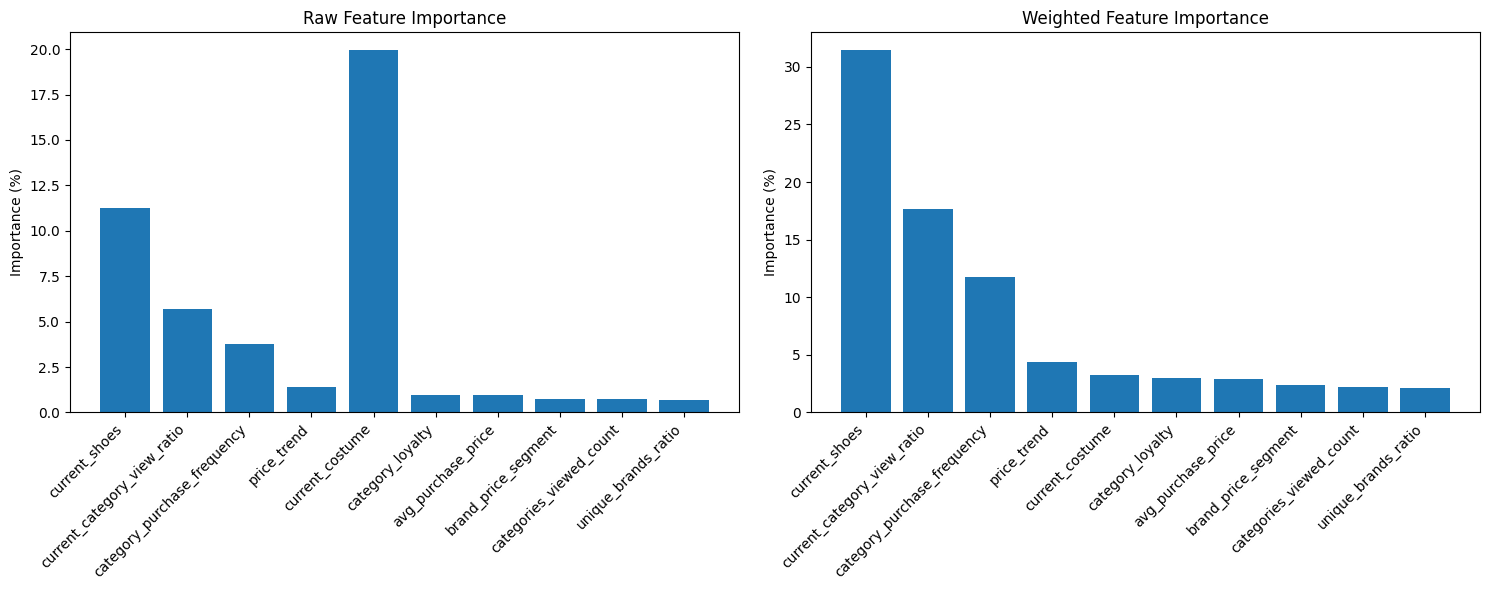

In [20]:
raw_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})

category_frequencies = sequences_filtered['current_subcategory'].value_counts(normalize=True)

def get_weighted_importance(row):
    feature = row['feature']
    importance = row['importance']
    
    if feature.startswith('current_'):
        category = feature.replace('current_', '')
        if category in category_frequencies.index:
            return importance * category_frequencies[category]
    return importance


raw_importance['weighted_importance'] = raw_importance.apply(get_weighted_importance, axis=1)
total_raw = raw_importance['importance'].sum()
total_weighted = raw_importance['weighted_importance'].sum()
raw_importance['raw_percentage'] = raw_importance['importance'] / total_raw * 100
raw_importance['weighted_percentage'] = raw_importance['weighted_importance'] / total_weighted * 100
raw_importance = raw_importance.sort_values('weighted_percentage', ascending=False)


print("\nFeature Importance (sorted by weighted importance):")
print("\nformat: Feature: Raw% → Weighted%")
print("-" * 40)
for _, row in raw_importance.iterrows():
    print(f"{row['feature']}: {row['raw_percentage']:.2f}% → {row['weighted_percentage']:.2f}%")


plt.figure(figsize=(15, 6))
top_10 = raw_importance.head(10)

plt.subplot(1, 2, 1)
plt.bar(range(len(top_10)), top_10['raw_percentage'])
plt.xticks(range(len(top_10)), top_10['feature'], rotation=45, ha='right')
plt.title('Raw Feature Importance')
plt.ylabel('Importance (%)')

plt.subplot(1, 2, 2)
plt.bar(range(len(top_10)), top_10['weighted_percentage'])
plt.xticks(range(len(top_10)), top_10['feature'], rotation=45, ha='right')
plt.title('Weighted Feature Importance')
plt.ylabel('Importance (%)')

plt.tight_layout()
plt.show()


In [21]:
# Create a copy of the data for predictions
prediction_df = pd.DataFrame()

# Process each user
for user_id, user_data in df.groupby('user_id'):
    # Create sequences for this user
    user_sequences = create_purchase_sequences(user_data,min_purchases=1)
    
    if not user_sequences.empty:
        # Get the last sequence for prediction
        last_sequence = user_sequences.iloc[-1:].copy()
        prediction_df = pd.concat([prediction_df, last_sequence])

# Handle rare categories
prediction_df.loc[~prediction_df['current_subcategory'].isin(valid_categories), 'current_subcategory'] = 'Other'

# Create dummy variables
pred_cat_dummies = pd.get_dummies(prediction_df['current_subcategory'], prefix='current')

# Prepare features in same order as training
X_pred = pd.DataFrame()
X_pred[feature_columns] = prediction_df[feature_columns]
for col in current_cat_dummies.columns:
    if col in pred_cat_dummies.columns:
        X_pred[col] = pred_cat_dummies[col]
    else:
        X_pred[col] = 0

# Scale features
X_pred_scaled = scaler.transform(X_pred)

# Make predictions
predictions = best_model.predict(X_pred_scaled)
probabilities = best_model.predict_proba(X_pred_scaled)
confidence_scores = np.max(probabilities, axis=1)

# Create results DataFrame
results_df = pd.DataFrame({
    'user_id': prediction_df['user_id'],
    'last_purchase_category': prediction_df['current_subcategory'],
    'most_likely_next_purchase': le.inverse_transform(predictions),
    'prediction_confidence': confidence_scores,
    'days_since_last_purchase': prediction_df['time_between_purchases'] / 24,  # Convert hours to days
    'total_orders': prediction_df['category_loyalty'] * prediction_df['categories_viewed_count']  # Approximate total orders
})

# Sort by confidence and show top predictions
print("\nTop 10 Most Confident Predictions:")
print(results_df.sort_values('prediction_confidence', ascending=False).head(10))

# Show distribution of predicted categories
print("\nPredicted Category Distribution:")
print(results_df['most_likely_next_purchase'].value_counts())

# Save predictions to CSV
results_df.to_csv('crm_targeting_recommendations.csv', index=False)


Top 10 Most Confident Predictions:
     user_id last_purchase_category most_likely_next_purchase  \
2  553544384                  shoes                     shoes   
1  514051428                  shoes                     shoes   
1  520891350                  shoes                     shoes   
1  542131802                  shoes                     shoes   
2  531991996                  shoes                     shoes   
1  517173292                  shoes                     shoes   
0  560324387                  shoes                     shoes   
1  556716479                  shoes                     shoes   
1  556546430                  shoes                     shoes   
0  514501005                  shoes                     shoes   

   prediction_confidence  days_since_last_purchase  total_orders  
2               0.999998                  6.024769      1.333333  
1               0.999997                  0.014502      1.500000  
1               0.999997                  0.798

In [22]:
# Load the CRM output file and check its structure
crm_df = pd.read_csv('crm_targeting_recommendations.csv')
print("Available columns:")
print(crm_df.columns.tolist())
print("\nFirst few rows of the data:")
print(crm_df.head())

Available columns:
['user_id', 'last_purchase_category', 'most_likely_next_purchase', 'prediction_confidence', 'days_since_last_purchase', 'total_orders']

First few rows of the data:
     user_id last_purchase_category most_likely_next_purchase  \
0  512363886                costume                     Other   
1  512364888                  shoes                     shoes   
2  512365769                  shoes                     shoes   
3  512366835                  shoes                     shoes   
4  512366935                  shoes                     shoes   

   prediction_confidence  days_since_last_purchase  total_orders  
0               0.926925                  0.005810      1.000000  
1               0.999938                  0.000856      2.000000  
2               0.999289                 41.458218     10.000000  
3               0.981269                  0.000949      0.000000  
4               0.999995                  1.889329      1.333333  


=== Category Transition Analysis ===

Overall Category Transition Statistics:
Same category recommendations: 91.8%
Different category recommendations: 8.2%

Category-specific Transition Analysis:
                        total_predictions  different_predictions  \
last_purchase_category                                             
shoes                                3371                    137   
costume                               208                     71   
jeans                                  44                     29   
Other                                  31                     14   
shirt                                  30                     17   
underwear                              26                      8   
dress                                  21                     10   
tshirt                                 21                     16   
jumper                                 20                      9   

                        transition_rate  
last_purchase

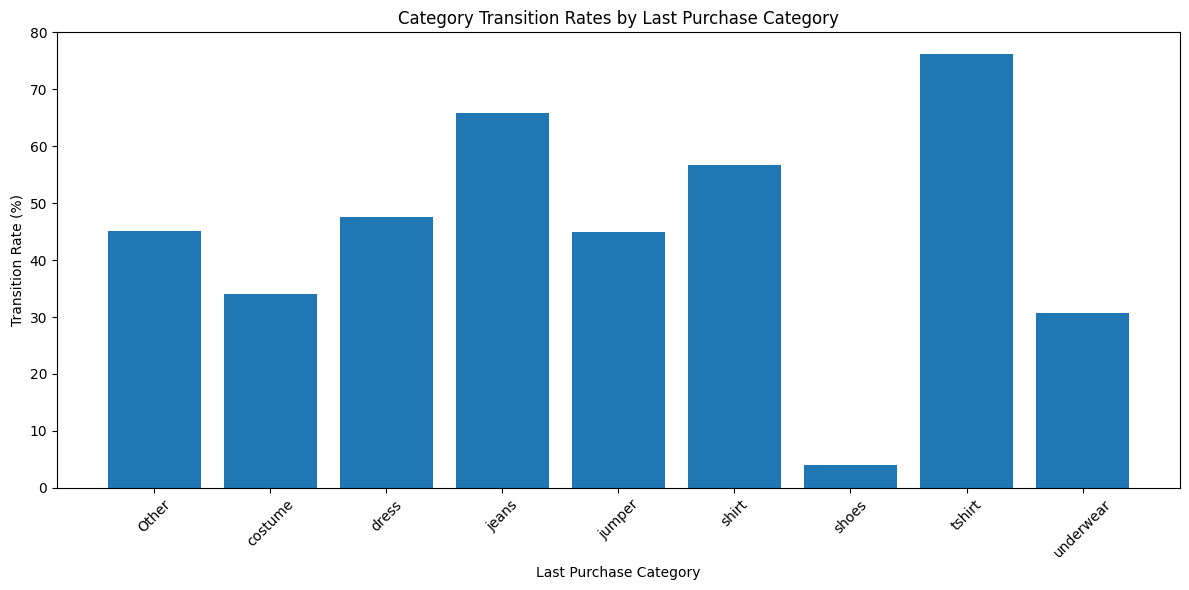

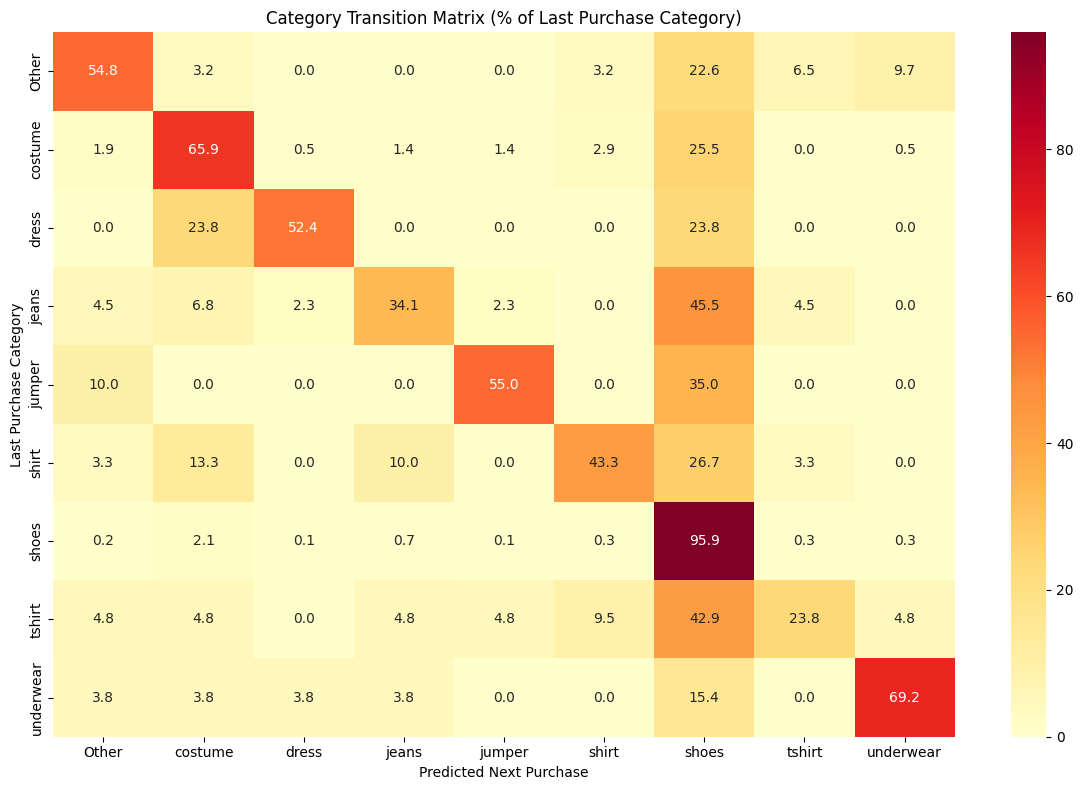


Confidence Level Analysis:
Average confidence when:
- Predicting same category: 99.8%
- Predicting different category: 93.0%

Transition Analysis by Customer Segment:
   Segment  Count  Avg Confidence  Transition Rate
0      New    206           0.965            0.510
1  Regular   3182           0.995            0.052
2    Loyal    362           0.986            0.113


In [23]:
# Analyzing Category Transitions
print("=== Category Transition Analysis ===\n")

# Calculate category transitions
same_category = crm_df['most_likely_next_purchase'] == crm_df['last_purchase_category']
different_category = ~same_category

print("Overall Category Transition Statistics:")
print(f"Same category recommendations: {same_category.mean()*100:.1f}%")
print(f"Different category recommendations: {different_category.mean()*100:.1f}%")

# Analyze transitions by current category
print("\nCategory-specific Transition Analysis:")
transition_analysis = pd.DataFrame({
    'total_predictions': crm_df.groupby('last_purchase_category').size(),
    'different_predictions': crm_df[different_category].groupby('last_purchase_category').size()
})
transition_analysis['transition_rate'] = (transition_analysis['different_predictions'] / 
                                        transition_analysis['total_predictions'] * 100)
print(transition_analysis.sort_values('total_predictions', ascending=False))

# Visualize category transitions
plt.figure(figsize=(12, 6))
plt.bar(transition_analysis.index, transition_analysis['transition_rate'])
plt.title('Category Transition Rates by Last Purchase Category')
plt.xlabel('Last Purchase Category')
plt.ylabel('Transition Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create transition matrix
transition_matrix = pd.crosstab(
    crm_df['last_purchase_category'], 
    crm_df['most_likely_next_purchase'], 
    normalize='index'
) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Category Transition Matrix (% of Last Purchase Category)')
plt.xlabel('Predicted Next Purchase')
plt.ylabel('Last Purchase Category')
plt.tight_layout()
plt.show()

# Analyze confidence levels for same vs different predictions
print("\nConfidence Level Analysis:")
print("Average confidence when:")
print(f"- Predicting same category: {crm_df[same_category]['prediction_confidence'].mean()*100:.1f}%")
print(f"- Predicting different category: {crm_df[different_category]['prediction_confidence'].mean()*100:.1f}%")

# Customer segment analysis
print("\nTransition Analysis by Customer Segment:")
crm_df['customer_segment'] = pd.cut(crm_df['total_orders'], 
                                   bins=[0, 1, 3, float('inf')],
                                   labels=['New', 'Regular', 'Loyal'])

segment_stats = []
for segment in ['New', 'Regular', 'Loyal']:
    segment_data = crm_df[crm_df['customer_segment'] == segment]
    segment_stats.append({
        'Segment': segment,
        'Count': len(segment_data),
        'Avg Confidence': segment_data['prediction_confidence'].mean(),
        'Transition Rate': (segment_data['most_likely_next_purchase'] != 
                          segment_data['last_purchase_category']).mean()
    })

segment_df = pd.DataFrame(segment_stats).round(3)
print(segment_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 


Overfitting Analysis:
Training Scores: mean=0.9594 (+/- 0.0136)
Validation Scores: mean=0.9478 (+/- 0.0160)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

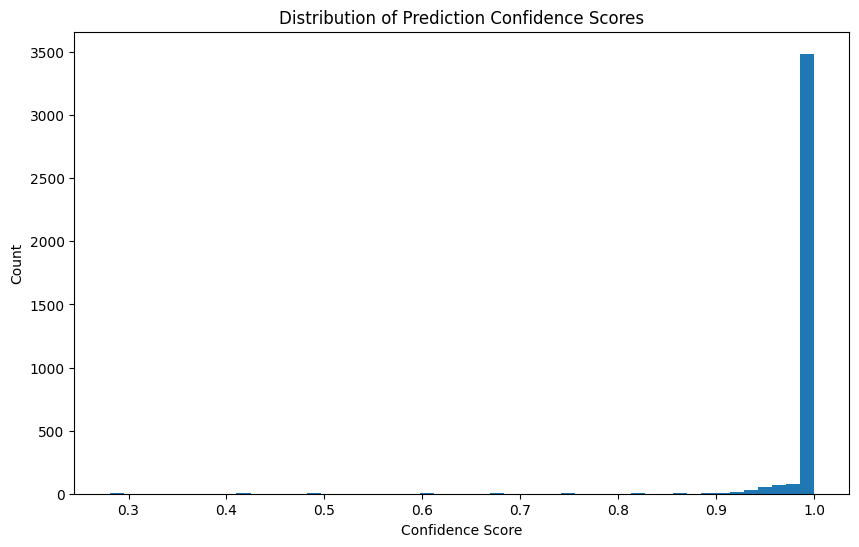


shoes:
Count: 7403
Avg Confidence: 0.9962
Std Confidence: 0.0343

costume:
Count: 434
Avg Confidence: 0.9750
Std Confidence: 0.0864

jeans:
Count: 111
Avg Confidence: 0.9367
Std Confidence: 0.1368

shirt:
Count: 65
Avg Confidence: 0.9701
Std Confidence: 0.0214

underwear:
Count: 54
Avg Confidence: 0.9812
Std Confidence: 0.0205

tshirt:
Count: 45
Avg Confidence: 0.8871
Std Confidence: 0.1611

dress:
Count: 38
Avg Confidence: 0.9382
Std Confidence: 0.1318

jumper:
Count: 31
Avg Confidence: 0.9496
Std Confidence: 0.0920


In [24]:
#Now looking further into potential overfitting. 

# Add cross-validation scores comparison
from sklearn.model_selection import cross_val_score

# Get training and validation scores
train_scores = cross_val_score(best_model, X_train, y_train, cv=5)
val_scores = cross_val_score(best_model, X_test, y_test, cv=5)

print("\nOverfitting Analysis:")
print(f"Training Scores: mean={train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f})")
print(f"Validation Scores: mean={val_scores.mean():.4f} (+/- {val_scores.std()*2:.4f})")

# Analyze prediction confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=50)
plt.title('Distribution of Prediction Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.show()

# Analyze performance by category frequency
category_counts = sequences_df['current_subcategory'].value_counts()
for category in category_counts.index:
    mask = prediction_df['current_subcategory'] == category
    if sum(mask) > 0:
        category_confidence = confidence_scores[mask]
        print(f"\n{category}:")
        print(f"Count: {category_counts[category]}")
        print(f"Avg Confidence: {category_confidence.mean():.4f}")
        print(f"Std Confidence: {category_confidence.std():.4f}")

In [25]:
# We might add regularization to avoid overfitting. But first check the model with a larger dataset

# xgb_params = {
#     'learning_rate': 0.05,  # Reduced from 0.1
#     'max_depth': 4,         # Reduced from 5
#     'n_estimators': 300,
#     'reg_alpha': 0.1,       # Add L1 regularization
#     'reg_lambda': 1.0,      # Add L2 regularization
#     'min_child_weight': 3   # Increase minimum observations required
# }

In [26]:
# Save model components
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/xgboost_model.joblib')
joblib.dump(scaler, '../models/scaler.joblib')
joblib.dump(le, '../models/label_encoder.joblib')
print("Model components saved successfully!")

Model components saved successfully!


In [27]:
# Create sequences for all customers (min_purchases=1)
print("Creating customer sequences...")
customer_data = create_purchase_sequences(df, min_purchases=1)

# Save to CSV
output_path = '../data/customer_data.csv'
customer_data.to_csv(output_path, index=False)
print(f"\nCustomer data saved to {output_path}")
print(f"Total customers: {len(customer_data)}")

# Display sample
print("\nSample of customer data:")
customer_data.head()

Creating customer sequences...

Customer data saved to ../data/customer_data.csv
Total customers: 8243

Sample of customer data:


,user_id,current_subcategory,next_subcategory,current_category_view_ratio,category_purchase_frequency,categories_viewed_count,total_category_views,view_intensity,time_between_purchases,category_loyalty,...,current_price,avg_purchase_price,price_variance,price_trend,category_avg_price,price_to_average_ratio,current_brand_loyalty,unique_brands_ratio,brand_price_segment,brand_category_combo
0,512363886,costume,belt,0.000000,0.5,1,15,107.569721,0.139444,1.0,...,136.43,81.085,78.269650,-0.811332,136.430,1.682555,0.0,0.5,1.00000,0.0
1,512364888,shoes,shoes,1.000000,1.0,1,1,48.648649,0.020556,2.0,...,28.83,46.720,25.300281,1.241068,46.720,0.617080,1.0,0.5,0.61708,1.0
2,512365769,shoes,shoes,0.847619,1.0,5,105,0.105528,994.997222,2.0,...,23.68,43.245,27.669088,1.652449,43.245,0.547578,0.5,1.0,1.00000,0.5
3,512366835,costume,shoes,0.000000,0.4,1,5,46.391753,0.107778,2.0,...,64.35,83.142,26.782952,0.004040,64.350,0.773977,0.0,0.4,1.00000,0.0
4,512366835,shoes,costume,0.000000,0.6,1,3,0.068310,43.917500,1.5,...,64.61,83.142,26.782952,-0.004024,95.670,0.777104,0.2,0.4,1.00000,0.2
